In [1]:
%matplotlib inline

# Imports

In [2]:
import glob
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from scipy.stats.mstats import zscore


###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Custom plotting parameters

In [3]:
import matplotlib
###Default for jupyter display
matplotlib.rcParams['figure.dpi']= 150

matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['legend.fontsize'] = 10
# matplotlib.rcParams['text.usetex'] = True

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load in the combined `.tsv` file and some notebook-wide variables


In [4]:
full_df = pd.read_csv('../Data/NCBI_phage_db/paper_dataset_11_2020_with_clusters.tsv', sep='\t')
phages_df = full_df[full_df['Host_species_id']==562]
print(phages_df.shape)
phages_df.head()

(1473, 40)


,Accession,SRA_Accession,Release_Date,Species,Genus,Family,Length,Sequence_Type,Nuc_Completeness,Genotype,...,Host_order_name,Host_family_id,Host_family_name,Host_genus_id,Host_genus_name,arbitrary_cluster_id,ranking_in_cluster,cluster_representative,CDS_density,CDS_number
0,NC_050154,NaN,2020-08-13T00:00:00Z,Escherichia phage D6,NaN,Myoviridae,91159,RefSeq,complete,NaN,...,Enterobacterales,543.0,Enterobacteriaceae,561.0,Escherichia,35,1,1.0,0.897366,118.0
10,NC_049941,NaN,2020-07-29T00:00:00Z,Stx2-converting phage Stx2a_WGPS2,NaN,Siphoviridae,58326,RefSeq,complete,NaN,...,Enterobacterales,543.0,Enterobacteriaceae,561.0,Escherichia,74,1,1.0,0.842300,66.0
11,NC_049942,NaN,2020-07-29T00:00:00Z,Escherichia phage JLK-2012,NaN,Siphoviridae,57198,RefSeq,complete,NaN,...,Enterobacterales,543.0,Enterobacteriaceae,561.0,Escherichia,77,1,1.0,0.860572,79.0
12,NC_049943,NaN,2020-07-29T00:00:00Z,Enterobacteria phage 2851,NaN,Siphoviridae,57248,RefSeq,complete,NaN,...,Enterobacterales,543.0,Enterobacteriaceae,561.0,Escherichia,67,3,NaN,NaN,NaN
13,NC_049944,NaN,2020-07-29T00:00:00Z,Stx2-converting phage Stx2a_WGPS8,NaN,Siphoviridae,55023,RefSeq,complete,NaN,...,Enterobacterales,543.0,Enterobacteriaceae,561.0,Escherichia,67,4,NaN,NaN,NaN


In [5]:
host_df = pd.read_csv('../Data/562_associated_data/ecoli.combined.tsv', sep='\t', index_col=0)
print(host_df.shape)
host_df.head()

(4018, 21)


,Genome_source,Start,Stop,Strand,CDS_seq,Upstream_seq,locus_tag,gene_id,aSD_binding,sec_struct,...,iCUB,GC_cds,GC_upstream,Start_accessibility,prot_abundance,trans_eff_2014,trans_eff_2019,essentiality_ds1,essentiality_ds2,essentiality
0,NC_000913.3,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,b0002,thrA,-5.42,-21.31,...,55.949262,0.530654,0.433333,-8.50,317.0,0.98,NaN,Non-essential,Non-essential,Non-essential
1,NC_000913.3,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,b0003,thrB,-6.51,-21.87,...,56.062386,0.562701,0.500000,-7.82,76.3,0.63,NaN,Non-essential,Non-essential,Non-essential
2,NC_000913.3,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,b0004,thrC,-3.40,-24.44,...,53.052776,0.528361,0.566667,-3.73,530.0,1.40,NaN,Non-essential,Non-essential,Non-essential
3,NC_000913.3,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,b0005,yaaX,-6.51,-17.15,...,50.705530,0.538721,0.400000,-9.77,NaN,0.28,NaN,Non-essential,Non-essential,Non-essential
4,NC_000913.3,5682,6459,-,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,GTCGGCATAAATTTCCTGCAAGGACTGGAT,b0006,yaaA,-4.00,-18.60,...,53.158862,0.496782,0.466667,-10.08,47.9,2.07,0.410931,Non-essential,Non-essential,Non-essential


In [6]:
###For prettier plotting
col_to_label_dict = {'aSD_binding': 'aSD binding energy (kcal/mol)',
                    'Start_accessibility': 'Start accessibility (kcal/mol)',
                    'prot_abundance': 'Protein abundance',
                    'iCUB': 'iCUB',
                    'GC_upstream': 'Upstream GC content',
                    'GC_cds': 'Coding sequence GC content',
                    'sec_struct': 'Start codon secondary\nstructure (kcal/mol)',
                    'sec_struct_bound': 'Ribosome bound\nstart codon secondary\nstructure (kcal/mol)',
                    'trans_eff_2014': 'Translational efficiency',\
                    'trans_eff_2019': 'Translational efficiency'}

mean_col_to_label_dict = {}
for key, val in col_to_label_dict.items():
    if val[0]==val[0].upper():
        mean_col_to_label_dict[key] = 'Mean ' + val[0].lower() + val[1:]
    else:
        mean_col_to_label_dict[key] = 'Mean ' + val


## Example comparison between host and phage

Note that phage T7 is `NC_001604`

In [124]:
ind_phage_df = pd.read_csv('../Data/NCBI_phage_db/phage_genomes/562_phage_genomes/NC_001604.clean.tsv',\
                       sep='\t')
assert len(set(ind_phage_df['Genome_source'])) == 1
phage_name = ind_phage_df.iloc[0]['Genome_source']
print(ind_phage_df.shape)
ind_phage_df.head()

(57, 13)


,Genome_source,Start,Stop,Strand,CDS_seq,Upstream_seq,aSD_binding,sec_struct,sec_struct_bound,iCUB,GC_cds,GC_upstream,Start_accessibility
0,NC_001604,925,1278,+,ATGGCTATGTCTAACATGACTTACAACAACGTTTTCGACCACGCTT...,TTCACTAATAACTGCACGAGGTAACACAAG,-5.42,-10.13,-3.81,50.525906,0.468927,0.400000,-6.32
1,NC_001604,1278,1433,+,ATGTCTACTACCAACGTGCAATACGGTCTGACCGCTCAAACTGTAC...,AGTCGAGGAGTACGAGGAGGATGAAGAGTA,-9.31,-19.01,-12.96,43.066882,0.455128,0.500000,-6.05
2,NC_001604,1496,1639,+,ATGTATATGCTTACTATCGGTCTACTCACCGCTCTAGGTCTAGCTG...,TATGATTATCACTTTACTTATGAGGGAGTA,-5.82,-19.87,-8.50,39.155014,0.458333,0.300000,-11.37
3,NC_001604,1636,1797,+,ATGATGAAGCACTACGTTATGCCAATCCACACGTCCAACGGGGCAA...,CATAGGAATCATCAAAGGGGCACTACGCAA,-5.53,-17.68,-7.52,42.406008,0.481481,0.466667,-10.16
4,NC_001604,2021,3100,+,ATGAACATTACCGACATCATGAACGCTATCGACGCAATCAAAGCAC...,TCTCATAACGAACATAAAGGACACAATGCA,-4.00,-7.46,-3.80,55.711182,0.493519,0.366667,-3.66


**Get statistics and perform basic visualization**

Looking at three different assessments of "significance", ranksums test, independent t-test, and a logistic regression framework.

In [127]:
# col_name = 'aSD_binding'
# col_name = 'sec_struct'
# col_name = 'Start_accessibility'
# col_name = 'GC_cds'
col_name = 'iCUB'


temp_df = host_df

print('Rank sums test:')
print(stats.ranksums(temp_df[col_name], ind_phage_df[col_name]))
print('Welchs T-test:')
print(stats.ttest_ind(temp_df[col_name], ind_phage_df[col_name], equal_var=False))
print()
host_name = temp_df['Genome_source'].value_counts().keys()[0]
concat_df = pd.concat((temp_df, ind_phage_df), ignore_index=True, sort=False)
concat_df['binary_predictor'] = 0
concat_df.at[concat_df[concat_df['Genome_source'] == phage_name].index, 'binary_predictor'] = 1 
# fitted = smf.ols('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
print('Logistic regression')
print(fitted.summary())
print(fitted.pvalues)
print()
print('Means (host, virus):')
print(temp_df[col_name].mean(), ind_phage_df[col_name].mean())

Rank sums test:
RanksumsResult(statistic=3.4239207458303933, pvalue=0.0006172461941712087)
Welchs T-test:
Ttest_indResult(statistic=3.369923749654847, pvalue=0.0013566013459806515)

Logistic regression
                           Logit Regression Results                           
Dep. Variable:       binary_predictor   No. Observations:                 4075
Model:                          Logit   Df Residuals:                     4073
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Nov 2020   Pseudo R-squ.:                 0.02848
Time:                        16:27:51   Log-Likelihood:                -291.42
converged:                       True   LL-Null:                       -299.97
Covariance Type:            nonrobust   LLR p-value:                 3.573e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

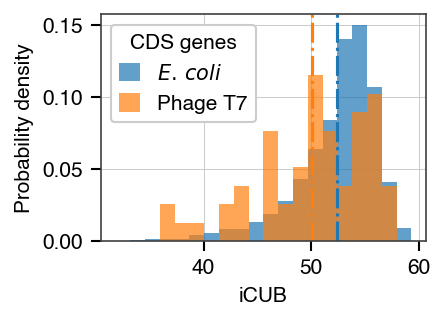

In [128]:
a, b = np.histogram(np.concatenate((temp_df[col_name].values, ind_phage_df[col_name].values)), 20)
fig, ax = plt.subplots(figsize=(2.8,2))
ax.hist(temp_df[col_name], bins=b, label='$E.\, coli$', density=True, alpha=0.7)
ax.hist(ind_phage_df[col_name], bins=b, label='Phage T7', density=True, alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.')
ax.axvline(ind_phage_df[col_name].mean(), color=colors[1], linestyle='-.')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_ylabel('Probability density')
plt.legend(title='CDS genes', framealpha=1.0, handlelength=1, handleheight=1)
plt.savefig(figs_dir + '/Ecoli_T7_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

# Extended analysis to many *E. coli* viruses

Compare each virus separately to all *E. coli* genes

In [156]:
# col_name = 'aSD_binding'
col_name = 'sec_struct'
# col_name = 'Start_accessibility'
# col_name = 'GC_cds'
# col_name = 'iCUB'

temp_df = host_df
host_mean = temp_df[col_name].mean()

mean_virus = []
p_vals = []
for index in phages_df[phages_df['cluster_representative']==1].index:
    phage_name = phages_df.loc[index]['Accession']
    phage_tsv = '../Data/NCBI_phage_db/phage_genomes/562_phage_genomes/{}.clean.tsv'.format(phage_name)
    ind_phage_df = pd.read_csv(phage_tsv, sep='\t')
    mean_virus.append(ind_phage_df[col_name].mean())
    t, p = stats.ttest_ind(temp_df[col_name], ind_phage_df[col_name], equal_var=False)
    p_vals.append(p)
    
###Correct the p-value distribution post-hoc
truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
#
#
#
zippy = list(zip(p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant no FDR (total={}):'.format(len(p_vals)), lside, rside)
#
zippy = list(zip(correct_p_vals, mean_virus))
lside = len([1 for i,j in zippy if i < 0.01 and j < host_mean])
rside = len([1 for i,j in zippy if i < 0.01 and j >= host_mean])
print('N significant w/ FDR(total={}):'.format(len(p_vals)), lside, rside)
#
zippy = list(zip(correct_p_vals, mean_virus))
lside = len([1 for i,j in zippy if j < host_mean])
rside = len([1 for i,j in zippy if j >= host_mean])
print('N on either side regardless of significance(total={}):'.format(len(p_vals)), lside, rside)
print('Host value: {}, and mean of viruses: {}'.format(host_mean, np.mean(mean_virus)))

N significant no FDR (total=254): 17 102
N significant w/ FDR(total=254): 13 99
N on either side regardless of significance(total=254): 102 152
Host value: -19.47593578894972, and mean of viruses: -18.489634524777806


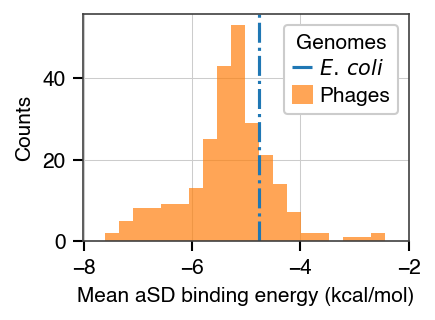

In [154]:
fig, ax = plt.subplots(figsize=(2.8, 2))
ax.hist(mean_virus, 20, color=colors[1], label='Phages', alpha=0.7)
ax.axvline(temp_df[col_name].mean(), color=colors[0], linestyle='-.', label='$E.\, coli$')
ax.set_ylabel('Counts')
ax.set_xlabel(mean_col_to_label_dict[col_name])
plt.legend(title='Genomes', framealpha=1.0, handlelength=1, handleheight=1, handletextpad=0.3, labelspacing=0.3)
if col_name == 'aSD_binding':
    ax.set_xlim(-8.01, -2.)
elif col_name == 'sec_struct':
    ax.set_xlim(-27.01, -13)
elif col_name == 'iCUB':
    ax.set_xlim(45, 60)
plt.savefig(figs_dir + '/Ecoli_allphage_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

**Comparing against different categories of *E. coli* genes**

In [101]:
col_name = 'aSD_binding'
# col_name = 'sec_struct'
# col_name = 'Start_accessibility'

###For the violin plot at the top
mean_virus = []
for index in phages_df[phages_df['cluster_representative']==1].index:
    phage_name = phages_df.loc[index]['Accession']
    phage_tsv = '../Data/NCBI_phage_db/phage_genomes/562_phage_genomes/{}.clean.tsv'.format(phage_name)
    ind_phage_df = pd.read_csv(phage_tsv, sep='\t')
    mean_virus.append(ind_phage_df[col_name].mean())
    
###For all the host information    
host_df_list = []
host_df_list.append(host_df)
percentiles_to_test = [25, 50, 75, 90, 95]
for i in percentiles_to_test:
    temp_df = host_df[host_df['prot_abundance'].isnull()==False]
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_df_list.append(temp_df[temp_df['prot_abundance']>=percentile_thresh])
host_df_list.append(host_df[(host_df['essentiality']=='Essential')])
host_df_list.append(host_df[(host_df['essentiality']=='Non-essential')])
#
host_means = [temp_df[col_name].mean() for temp_df in host_df_list]
host_errs = [temp_df[col_name].std()/np.sqrt(temp_df.shape[0]) for temp_df in host_df_list]

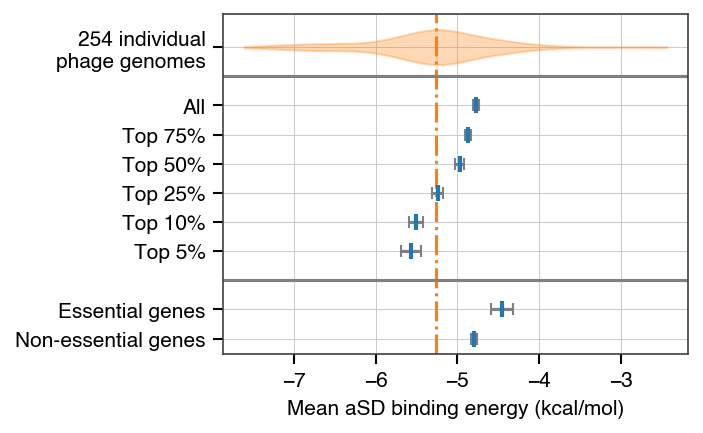

In [102]:
###Plotting
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))

fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#Plotting two here to hack the line/dot overlaps
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='|', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=2, markersize=8, mew=2)
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, capsize=3, capthick=1, elinewidth=1)
#
ax.axhline(-3, c='gray')
ax.set_xlabel(mean_col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['{} individual\nphage genomes'.format(len(mean_virus)),\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
# if col_name == 'aSD_binding':
#     ax.set_xlim(-7.99, -3.1)
# elif col_name == 'sec_struct':
#     ax.set_xlim(-26, -13) 
plt.savefig(figs_dir + '/Ecoli_{}_categories.png'.format(col_name), dpi=300, bbox_inches='tight')

**And getting statistics for all those comparisons**

Currently takes a minute or two to run this but... meh? I'm pretty okay with it.

In [103]:
results = []
for temp_df in host_df_list:
    beta_vals = []
    p_vals = []
    for index in phages_df[phages_df['cluster_representative']==1].index:
        phage_name = phages_df.loc[index]['Accession']
        phage_tsv = '../Data/NCBI_phage_db/phage_genomes/562_phage_genomes/{}.clean.tsv'.format(phage_name)
        ind_phage_df = pd.read_csv(phage_tsv, sep='\t')
        assert len(list(ind_phage_df['Genome_source'].value_counts().keys())) == 1
        ###Welch's T-test, not assuming equal variance
        t, p = stats.ttest_ind(temp_df[col_name], ind_phage_df[col_name], equal_var=False)
        p_vals.append(p)
        ###Logistic regression to get the directionality of the difference
        concat_df = pd.concat((temp_df, ind_phage_df), ignore_index=True, sort=False)
        concat_df['binary_predictor'] = 0
        concat_df.at[concat_df[concat_df['Genome_source'] == phage_name].index, 'binary_predictor'] = 1 
        fitted = smf.logit('binary_predictor ~ {}'.format(col_name), data=concat_df).fit(disp=0)
        beta_vals.append(fitted.params[1])
    truth_array, correct_p_vals = multi.fdrcorrection(p_vals, alpha=0.01)
    zippy = list(zip(correct_p_vals, beta_vals))
    lside = len([1 for i,j in zippy if i < 0.01 and j < 0])
    rside = len([1 for i,j in zippy if i < 0.01 and j >= 0])
    results.append((lside, rside))

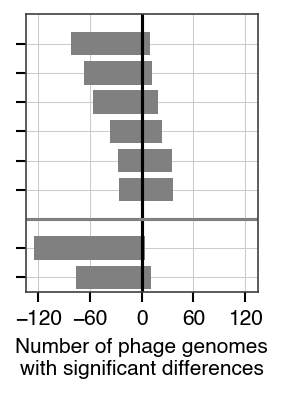

In [104]:
fig, ax = plt.subplots(figsize=(2,2.45))
l_bar = ax.barh(all_y_vals, [-1*i[0] for i in results], height=0.4,\
             color='gray')
r_bar = ax.barh(all_y_vals, [i[1] for i in results], height=0.4,\
            color='gray')
ax.set_yticklabels('')
ax.set_xticks([-120, -60, 0, 60, 120])
# ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_xlim(-135, 135)
ax.axvline(0, c='k')
ax.set_yticks(all_y_vals[::-1])
ax.set_ylim(-4.25, 0.5)
ax.axhline(-3, c='gray')


ax.set_xlabel('Number of phage genomes\nwith significant differences')
plt.savefig(figs_dir + '/Ecoli_{}_categories_bar.png'.format(col_name), dpi=300, bbox_inches='tight')

# Multi-variate analysis

In [173]:
temp_df = host_df

comparison_vals_a = []
comparison_vals_b = []
p_vals_a = []
p_vals_b = []

for index in phages_df[phages_df['cluster_representative']==1].index:
    phage_name = phages_df.loc[index]['Accession']
    phage_tsv = '../Data/NCBI_phage_db/phage_genomes/562_phage_genomes/{}.clean.tsv'.format(phage_name)
    ind_phage_df = pd.read_csv(phage_tsv, sep='\t')
    assert len(list(ind_phage_df['Genome_source'].value_counts().keys())) == 1
    #
    concat_df = pd.concat((temp_df, ind_phage_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 0
    concat_df.at[concat_df[concat_df['Genome_source'] == phage_name].index, 'binary_predictor'] = 1
#     fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct)', data=concat_df).fit(disp=0)    
    fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct) + zscore(GC_cds) + zscore(iCUB)', data=concat_df).fit(disp=0)

    comparison_vals_a.append(fitted.params[1])
    comparison_vals_b.append(fitted.params[2])

    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

In [174]:
truth_array_a, correct_p_vals_a = multi.fdrcorrection(p_vals_a, alpha=0.01)
print('Number significantly different aSD binding:', np.sum(truth_array_a))
truth_array_b, correct_p_vals_b = multi.fdrcorrection(p_vals_b, alpha=0.01)
print('Number significantly different sec_struct:', np.sum(truth_array_b))

Number significantly different aSD binding: 108
Number significantly different sec_struct: 71


In [177]:
tl = 0
bl = 0
tr = 0
br = 0
for i,j,k,l in zip(comparison_vals_a, comparison_vals_b, correct_p_vals_a, correct_p_vals_b):
    if k < 0.01 or l < 0.01:
        if i < 0 and j < 0:
            bl += 1
        if i < 0 and j > 0:
            tl += 1
        if i > 0 and j < 0:
            br += 1
        if i > 0 and j > 0:
            tr += 1
print(tl, bl, tr, br)

98 31 1 9


Text(0, 0.5, 'Effect size\n(Start codon secondary structure)')

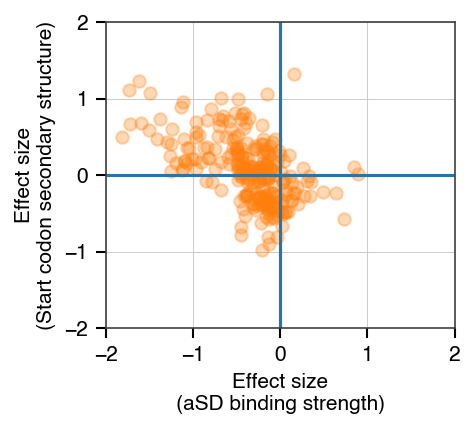

In [176]:
fig, ax = plt.subplots(figsize=(3,2.7))
ax.plot(comparison_vals_a, comparison_vals_b, marker='o', linestyle='', c=colors[1], alpha=0.3)
ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
# ax.set_xlim(-6.5, 6.5)
# ax.set_ylim(-6.5, 6.5)
ax.set_xlabel('Effect size\n(aSD binding strength)')
ax.set_ylabel('Effect size\n(Start codon secondary structure)')
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter.png'.format(col_name), dpi=300, bbox_inches='tight')
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter_withcovariates.png'.format(col_name), dpi=300, bbox_inches='tight')

# Getting lifestyle predictions

In [151]:
lifestyle_df = pd.read_csv('../Data/lifestyle_results_BACPHLIP.tsv', sep='\t')
lifestyle_df = lifestyle_df[lifestyle_df['host_id']==int(562)]
print(lifestyle_df.shape)
lifestyle_df.head()

(254, 4)


,host_id,phage_id,phage_lifestyle,lifestyle_probability_difference
833,562,NC_050154,Temperate,0.900
834,562,NC_049941,Temperate,0.950
835,562,NC_049942,Temperate,0.975
836,562,NC_049924,Temperate,0.975
837,562,NC_049926,Temperate,1.000


In [118]:
lifestyle_df.loc['NC_001604'] #T7
# lifestyle_df.loc['NC_001416'] #Phage lambda

host_id                                  562
phage_lifestyle                     Virulent
lifestyle_probability_difference    0.997166
Name: NC_001604, dtype: object

# Re-doing analyses to assess robustness

In [147]:
temp_df = host_df

comparison_vals_a = []
comparison_vals_b = []
p_vals_a = []
p_vals_b = []
lifestyle_vals = []

for index in phages_df[phages_df['cluster_representative']==1].index:
    phage_name = phages_df.loc[index]['Accession']
    phage_tsv = '../Data/NCBI_phage_db/phage_genomes/562_phage_genomes/{}.clean.tsv'.format(phage_name)
    ind_phage_df = pd.read_csv(phage_tsv, sep='\t')
    assert len(list(ind_phage_df['Genome_source'].value_counts().keys())) == 1
    
    ind_lifestyle = lifestyle_df.loc[phage_name]['phage_lifestyle']
    ind_lifestyle_prob = lifestyle_df.loc[phage_name]['lifestyle_probability_difference']
    if ind_lifestyle_prob < 0.95:
        continue
    lifestyle_vals.append(ind_lifestyle)    

    #
    concat_df = pd.concat((temp_df, ind_phage_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 0
    concat_df.at[concat_df[concat_df['Genome_source'] == phage_name].index, 'binary_predictor'] = 1
#     fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct)', data=concat_df).fit(disp=0)    
    fitted = smf.logit('binary_predictor ~ zscore(aSD_binding) + zscore(sec_struct) + zscore(GC_cds) + zscore(iCUB)', data=concat_df).fit(disp=0)

    comparison_vals_a.append(fitted.params[1])
    comparison_vals_b.append(fitted.params[2])

    p_vals_a.append(fitted.pvalues[1])
    p_vals_b.append(fitted.pvalues[2])

In [148]:
quick_df = pd.DataFrame(
    {'aSD_binding': comparison_vals_a,
     'sec_struct': comparison_vals_b,
     'lifestyle': lifestyle_vals
    })
print(quick_df.shape)

(143, 3)


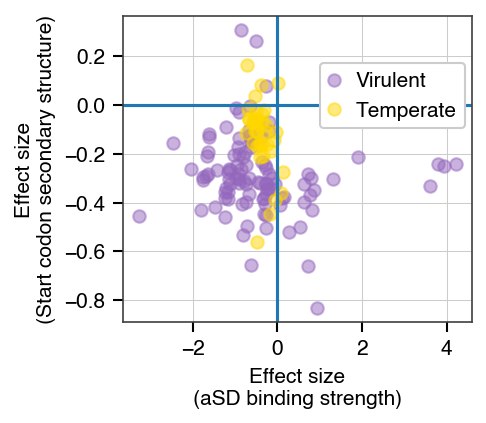

In [149]:
fig, ax = plt.subplots(figsize=(3,2.7))
ax.plot(quick_df[quick_df['lifestyle']=='Virulent']['aSD_binding'],
        quick_df[quick_df['lifestyle']=='Virulent']['sec_struct'], 
        marker='o', linestyle='', c=colors[4], alpha=0.5,
        label='Virulent')
ax.plot(quick_df[quick_df['lifestyle']=='Temperate']['aSD_binding'],
        quick_df[quick_df['lifestyle']=='Temperate']['sec_struct'], 
        marker='o', linestyle='', c='gold', alpha=0.5,
        label='Temperate')
ax.axvline(0, c=colors[0])
ax.axhline(0, c=colors[0])
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
ax.set_xlabel('Effect size\n(aSD binding strength)')
ax.set_ylabel('Effect size\n(Start codon secondary structure)')
leg = plt.legend(loc=1, framealpha=1.0, handlelength=0.5, handleheight=0.5)
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
bb.y1 -=0.12
bb.x1 += 0.01
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter_lifestyle.png'.format(col_name), dpi=300, bbox_inches='tight')
# plt.savefig(figs_dir + '/Ecoli_multivariate_scatter_withcovariates_lifestyle.png'.format(col_name), dpi=300, bbox_inches='tight')